# Classification
_Build a machine learning model to classify a handwritten digit using a linear model._

In [1]:
# Imports required packages

import pandas as pd
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, \
    f1_score, precision_recall_curve, roc_curve, roc_auc_score, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

## Retrieving & Analyzing the Data

The _MNIST_ is a database of handwritten digits with 784 features. The raw data available at http://yann.lecun.com/exdb/mnist/. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. The images were centered in a 28x28 image by computing the center of mass of the pixels, and translated the image so as to position this point at the center of the 28x28 field.

In [2]:
# Fetches the data set and caches it

# NOTE: This step may take several seconds to complete as it downloads 
# the data from web and then caches it locally

mnist = fetch_openml("mnist_784", as_frame=False)

In [10]:
# Checks the available bunch objects
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


So, mnist.data and mnist.target will provide the data set and targets, respectively. Other properties might not be applicable as far as this experiment is concerned.

## Exploratory Data Analysis (EDA)

In [11]:
# Finds the shape of the data
print(mnist.data.shape)

(70000, 784)


In [12]:
# Similarly, finds the shape of the target
print(mnist.target.shape)

(70000,)


In [13]:
# Let's view target of first few observations
print(mnist.target[:20])

['5' '0' '4' '1' '9' '2' '1' '3' '1' '4' '3' '5' '3' '6' '1' '7' '2' '8'
 '6' '9']


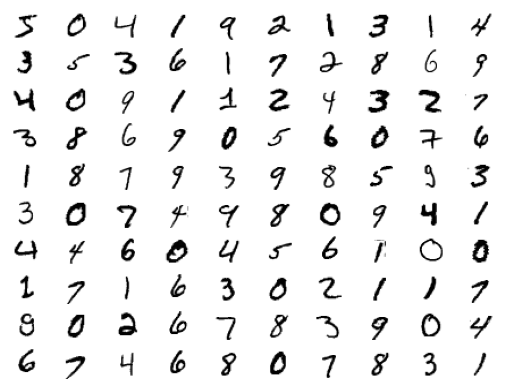

In [16]:
# Let's plot first 100 handwritten digits in a 10x10 subplots in a figure

for idx, image_data in enumerate(mnist.data[:100]):
    plt.subplot(10, 10, idx + 1)
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap = "binary")
    plt.axis("off")

plt.show()

## Modeling a Binary Classifier
Though the data set is a multiclass data set, let's first convert this problem as binary classification problem. It will just predict 5 and not-5 - the two classes.

In [3]:
# Converts target type from 'char' to 'integer'
mnist.target = mnist.target.astype(int)

In [4]:
# Creates binary vector for target - True for all 5s and False for all other digits
y_5 = (mnist.target == 5)

print(y_5)

[ True False False ... False  True False]


In [5]:
# Split the data set into train and test data set.

# NOTE: Data set is already shuffled, and no further shuffling is being performed here.
# As recommended for this dataset, train and test set ratio maintained is 60000:10000.

X_train, X_test, y_train_5, y_test_5 = \
    mnist.data[:60000], mnist.data[60000:], y_5[:60000], y_5[60000:]

In [27]:
# Let's start with Stochastic Gradient Descent (SGD) classifier as this classifier
# has advantage of handling large data sets efficiently

# Initialize the classifier (with default parameters)
# NOTE: This step may take several seconds to complete
sgd_clf = SGDClassifier(n_jobs=-1, random_state=42)

# Fits the model on the train set
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(n_jobs=-1, random_state=42)

## Measuring Model Performance

### Measuring Out-of-Sample Accuracy Score

In [34]:
sgd_clf_predictions_train = sgd_clf.predict(X_train)
sgd_clf_accuracy_train = accuracy_score(y_train_5, sgd_clf_predictions_train)

sgd_clf_predictions_test = sgd_clf.predict(X_test)
sgd_clf_accuracy_test = accuracy_score(y_test_5, sgd_clf_predictions_test)

print("SGD Classifier Classification Accuracy: \n{:.3f} [Train], \n{:.3f} [Test]".format(
    sgd_clf_accuracy_train, sgd_clf_accuracy_test))

SGD Classifier Classification Accuracy: 
0.952 [Train], 
0.949 [Test]


### Measuring Accuracy Score Over Cross-Validation

In [49]:
# Initialize the classifier (with default parameters)
sgd_clf = SGDClassifier(n_jobs=-1, random_state=42)

# For each fold, the model gets trained on the remaining folds and then 
# performs predictions on each sample on that fold
cv_predictions = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=5, n_jobs=-1, verbose=3, method="predict")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.3s remaining:   21.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.3s finished


In [50]:
# Checks the shape of the predictions
cv_predictions.shape

(60000,)

In [51]:
# Calculates the CV accuracy
print("Cross-validation Accuracy: {:.3f}".format(accuracy_score(y_train_5, cv_predictions)))


Cross-validation Accuracy: 0.960


The cross-valication score can also be generated by calling method `cross_val_score` as shown below.

```python
sgd_clf = SGDClassifier(n_jobs=-1, random_state=42)

sgd_clf_accuracy_cv = cross_val_score(
    sgd_clf, X_train, y_train_5, scoring="accuracy", cv=5, n_jobs=-1, verbose=3)`

np.mean(sgd_clf_accuracy_cv)
```

The above accuracy may not be a correct approximation of the model's performance because if the model just predicts _False_ for all the validation test data then accuracy will anyway be around 90% as non-5 images occupy 90% of the total validation test data in each fold. So, this demonstrates that **accuracy is not always the preferred performance measure for classifiers**.

### Confusion Matrix

A better way evaluate performance of the classifier is to count number of times each class is correctly predicted across all folds. It outputs a matrix where one axis is for actual class and other axis is for predicted class.

In [53]:
# Builds confusion matrix
cv_confusion_matrix = confusion_matrix(y_train_5, cv_predictions)

# Prints the confusion matrix
print("Confusion matrix:\n", cv_confusion_matrix)

Confusion matrix:
 [[53115  1464]
 [  916  4505]]


In [62]:
# Converts the array representation of confusion matrix into DataFrame for easy understanding
pd.DataFrame(
    cv_confusion_matrix, index=["True non-5", "True 5"], columns=["Predicted as non-5", "Predicted as 5"])

,Predicted as non-5,Predicted as 5
True non-5,53115,1464
True 5,916,4505


In [59]:
true_positive = cv_confusion_matrix[1][1]

false_positive = cv_confusion_matrix[0][-1]

true_negative = cv_confusion_matrix[0][0]

false_negative = cv_confusion_matrix[1][0]

print("True Positive: {}\nFalse Positive: {}\nTrue Negative: {}\nFalse Negative: {}".format(
    true_positive, false_positive, true_negative, false_negative))


True Positive: 4505
False Positive: 1464
True Negative: 53115
False Negative: 916


In [65]:
# Calculates the CV accuracy from confusion matrix
print("Cross-validation Accuracy: {:.3f}".format(
    (true_positive+true_negative)/(true_positive+false_positive+true_negative+false_negative)
))

Cross-validation Accuracy: 0.960


### Precision/Recall Trade-off

**Accuracy of the Positive Predictions**

$$precision=\frac{True Positive (TP)}{True Positive (TP)+False Positive (FP)}$$

**True Positive Rate (TPR) or Sensitivity**

$$recall=\frac{True Positive (TP)}{True Positive (TP)+False Negative (FN)}$$
**F1 Score - Harmonic Mean of Precision and Recall**

$$F_1=\frac{2}{\frac{1}{Precision}+\frac{1}{Recall}}=2 \times \frac{Precision \times Recall}{Precision+Recall} = \frac{TP}{TP + \frac{FN+FP}{2}}$$

In [71]:
# Calculates precision - measure of accuracy for positive predictions
cv_precision_score = precision_score(y_train_5, cv_predictions)

# Calculates recall - measure of accuracy to find all positive observations
cv_recall_score = recall_score(y_train_5, cv_predictions)

# Calculates F1 score - the harmonic mean of precision and recall
cv_f1_score = f1_score(y_train_5, cv_predictions)

print("Precision: {:.3f}\nRecall: {:.3f}\nF1 Score: {:.3f}".format(
    cv_precision_score, cv_recall_score, cv_f1_score))

Precision: 0.755
Recall: 0.831
F1 Score: 0.791


The SGD Classifier computes a score based on a _decision function_. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class. If the threshold is raised, precision will increase, and recall will increase when the threshold is lowered.

SGD Classifier does not allow to set the threshold directly, but it provides the decision scores that it uses to make predictions. Then any threshold can be used to make positive and negative predictions based on whether the prediction scores are over or under the set threshold, respectively.

In [73]:
# Fetches cross-validation prediction scores instead of predictions
# NOTE: This step may take several seconds to complete

cv_prediction_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=5, n_jobs=-1, verbose=3, method="decision_function")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.1s remaining:   21.1s


[  4411.53413566 -14087.12193543 -21565.51993633 ...   9394.4695853
  -2918.25117218  -9160.6081938 ]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.0s finished


In [74]:
# Prints the predictions scores fore reference
print(cv_prediction_scores)

[  4411.53413566 -14087.12193543 -21565.51993633 ...   9394.4695853
  -2918.25117218  -9160.6081938 ]


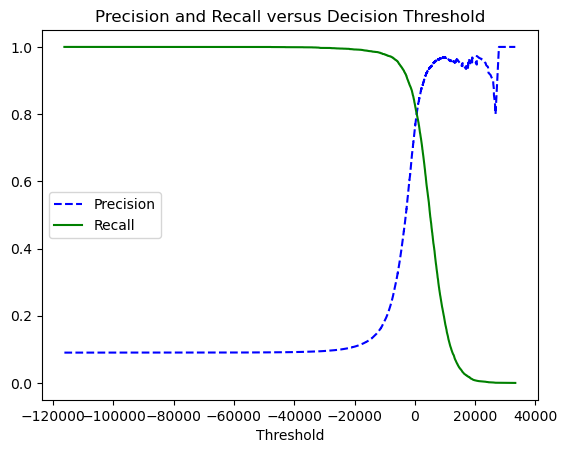

In [76]:
# Now, retrieve additional precision and retrieve data to draw precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, cv_prediction_scores)

plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.title("Precision and Recall versus Decision Threshold")
plt.legend()
plt.show()

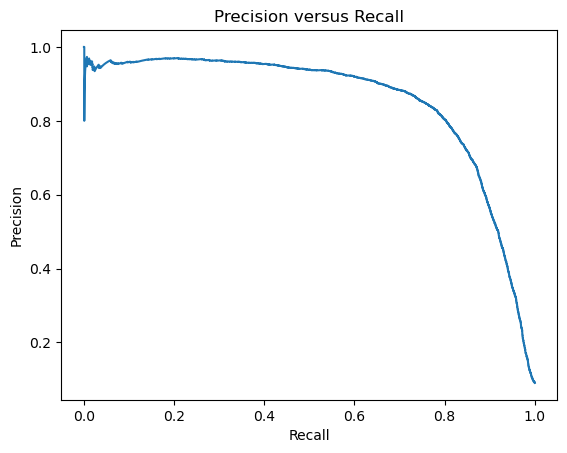

In [77]:
# Another way to select good precision/recall trade-off is to 
# plot the precision directly against the recall 

plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision versus Recall")
plt.show()

It is clear from the above plot that precision starts falling sharply after 80%. So, precision-recall trade-off can be selected just before that drop. If certain application requires higher precision, for example 90%, then the threshold can be decided as follows.

In [81]:
expected_precision = 0.90
required_threshold = thresholds[np.argmax(precisions >= expected_precision)]

print("Required threshold for {:.0f}% percent precision is {:.3f}".format(
    expected_precision*100, required_threshold))

Required threshold for 90% percent precision is 3045.926


In [82]:
# Now, predicts with that threshold
cv_prediction_90_precision = (cv_prediction_scores >= required_threshold)

# Calculates the precision and recall
print("Precision: {:.3f}".format(precision_score(y_train_5, cv_prediction_90_precision)))
print("Recall: {:.3f}".format(recall_score(y_train_5, cv_prediction_90_precision)))

Precision: 0.900
Recall: 0.659


### The Receiver Operating Characteristic (ROC) Curve

The ROC is also another common tool used with binary classifiers. It is similar to Precision-Recall curve, but instead plotting precison versus recall, it plots True Positive Rate (TPR) - also called Recall against False Positive Rate (FPR).

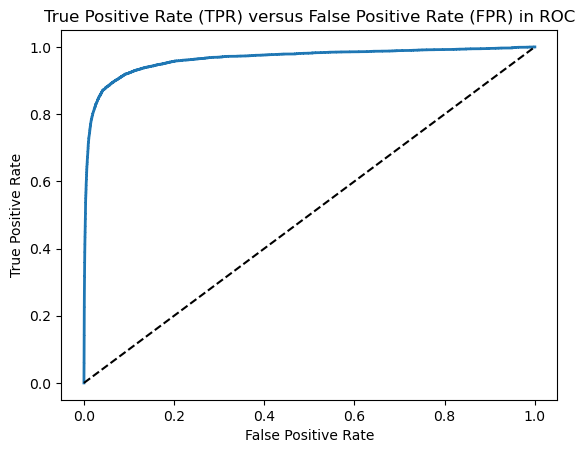

In [84]:
# Computes TRP and FPR
fpr, tpr, thresholds = roc_curve(y_train_5, cv_prediction_scores)

# Plots the ROC curve
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("True Positive Rate (TPR) versus False Positive Rate (FPR) in ROC")
plt.show()

One way to compare classifiers is to measure the Area Under Curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

In [ ]:
# Calculates ROC AUC for SGD classifier
print("ROC AUC Score of SGD classifier: {:.3f}".format(roc_auc_score(y_train_5, cv_prediction_scores)))

ROC AUC Score for SGD classifier: 0.965


**Rule of Thumb:** As a rule of thumb, Precisio-Recall curve should be used if positive class is rare, otherwise ROC curve can be used.

### Model Performance Comparison

Compares the performance of SGD classifier with that of the random forest classifier.

In [87]:
# Initializes Random Forest classifier with default parameters
rf_clf = RandomForestClassifier(n_jobs=-1, random_state=42)

# Predicts the probabilities over cross-validation
# NOTE: This step may take several seconds to complete
cv_predictions_probas = cross_val_predict(
    rf_clf, X_train, y_train_5, cv=5, n_jobs=-1, verbose=3, method="predict_proba")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   28.3s remaining:   42.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.3s finished


In [88]:
# Prints prediction probabilities for reference
print(cv_predictions_probas)

[[0.14 0.86]
 [0.99 0.01]
 [0.98 0.02]
 ...
 [0.01 0.99]
 [0.96 0.04]
 [0.96 0.04]]


Each row from the above CV prodictions probabilities is for prediction for each observation, and values in list represent probability distribution amongst classes (there are two classes here).

In [91]:
# Let's consider CV prediction probability only for positive class as it is 
# required to perform comparison with other classifier

cv_predictions_probas = cv_predictions_probas[:, 1]
print(cv_predictions_probas)

[0.86 0.01 0.02 ... 0.99 0.04 0.04]


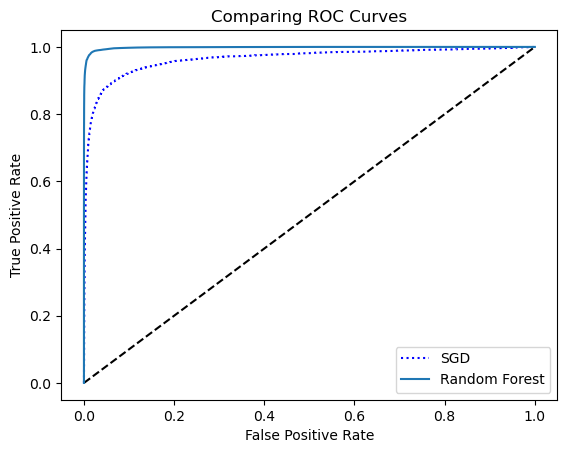

In [92]:
# Computes FPR and TPR over prediction probabilities from random forest classifier
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train_5, cv_predictions_probas)

# Now, plots ROC curves for both the models to compare performance

plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot([0, 1], [0, 1], "k--")

plt.plot(fpr_rf, tpr_rf, label="Random Forest")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("Comparing ROC Curves")
plt.show()

Random Forest ROC curves looks much better than the SGD Classifier's.

In [93]:
# Calculates ROC AUC score of random rorest classifier
print("ROC AUC Score of Random Forest Classifier: {:.3f}".format(roc_auc_score(y_train_5, cv_predictions_probas)))

ROC AUC Score of Random Forest Classifier: 0.998


The above ROC AUC score of random rorest classifier was found to be more than that of SGD classifier.

In [94]:
# Now, retrieves concrete predictions from random forest classifier
cv_predictions_rf = cv_predictions_probas >= 0.5

In [104]:
# Prints the performance summary of random forest classifier

print("Random Forest Performance Summary:\n\n" \
      "Precision: {:.3f}\nRecall: {:.3f}\nF1-Score: {:.3f}\nROC AUC Score: {:.3f}".format(
          precision_score(y_train_5, cv_predictions_rf),
          recall_score(y_train_5, cv_predictions_rf),
          f1_score(y_train_5, cv_predictions_rf),
          roc_auc_score(y_train_5, cv_predictions_probas)
))

Random Forest Performance Summary:

Precision: 0.990
Recall: 0.879
F1-Score: 0.931
ROC AUC Score: 0.998


## Multiclass Classification

### Using Binary Classifier for Multiclass Classification Task

In [7]:
# First, seperates the labels for train and test set
y_train, y_test = mnist.target[:60000], mnist.target[60000:]

In [109]:
# Initializes SVM classifier
svm_clf = SVC(random_state=42)

# Fits the model with train set
# NOTE: This step may take several minutes to complete
svm_clf.fit(X_train, y_train)

SVC(random_state=42)

In [114]:
# Takes one sample from test set, performs prediction and then compares with the actual label
print("Prediction:", svm_clf.predict(X_test[:1]))
print("Actual Label:", y_test[:1])

Prediction: [7]
Actual Label: [7]


In [116]:
# Retrieves decision scores against all classes. 

svm_clf_decision_scores = svm_clf.decision_function(X_test[:1])
print("Decision Scores:", svm_clf_decision_scores)

Decision Scores: [[ 3.80895496 -0.30212376  6.19343167  8.29375992  1.71167996  4.76436748
   0.69153837  9.31783975  2.75699419  7.28292338]]


In [118]:
# The class with the highest score gets predicted.
svm_clf.classes_[svm_clf_decision_scores.argmax()]

7

SVM classifier internally uses OvO strategy to train `45 (N * (N-1) / 2)` [`N` is the number of classes] binary classifiers and printed prediction scores from the duets.

OvO and OvR strategy can also be forced directly through the class `OneVsOneClassifier` and `OneVsRestClassifier`, respctively.

Let's try classification with the `OneVsRest` strategy.

In [6]:
# Initializes OvR classifier with SVC as estimator
ovr_clf = OneVsRestClassifier(SVC(random_state=42), n_jobs = -1)

# Fits the model
# NOTE: This step may take several tens of minutes to complete
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(random_state=42), n_jobs=-1)

In [7]:
# Takes one sample from test set, performs prediction and then compares with the actual label
print("Prediction:", ovr_clf.predict(X_test[:1]))
print("Actual Label:", y_test[:1])

Prediction: ['7']
Actual Label: ['7']


In [9]:
# Checks for the number of internal estimators created out of OvR strategy
print("Number of Estimators:", len(ovr_clf.estimators_))

Number of Estimators: 10


### Using Multiclass Classifier for Multiclass Classification Task

Models such as SGD classifier and random forest classifier have built-in feature to handle multiple classes. So, OvR or OvO strategy does not have to be specified for these models.

In [11]:
# Initialize the classifier
sgd_clf = SGDClassifier(n_jobs=-1, random_state=42)

# Calculates cross-validation score for multiclass prediction
sgd_clf_multiclass_accuracy_cv = cross_val_score(
    sgd_clf, X_train, y_train, scoring="accuracy", cv=5, n_jobs=-1, verbose=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END ................................ score: (test=0.881) total time= 1.8min
[CV] END ................................ score: (test=0.887) total time= 1.8min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.8min


[CV] END ................................ score: (test=0.881) total time= 1.8min
[CV] END ................................ score: (test=0.883) total time= 1.9min
[CV] END ................................ score: (test=0.866) total time= 1.9min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


In [12]:
# Shows the multiclass prediction performance of SGD classifier
print("Multiclass Prediction Performance of SGD Classifier: {:.1f}%".format(
    np.mean(sgd_clf_multiclass_accuracy_cv) * 100))

Multiclass Prediction Performance of SGD Classifier: 88.0%


## Error Analysis

Before performing error analysis, let's first scale the feature values as they presently range from 0 to 255.

In [15]:
# Instantiate scaler object
std_scaler = StandardScaler()

# Scales the feature values
#X_train_scaled = std_scaler.fit_transform(X_train.astype(np.float64))
X_train_scaled = std_scaler.fit_transform(X_train)

In [18]:
# Initializes the classifier (with default parameters)
sgd_clf = SGDClassifier(n_jobs=-1, random_state=42)

# Performs cross-validation predictions
# NOTE: This step may take several minutes to complete
cv_predictions = cross_val_predict(
    sgd_clf, X_train_scaled, y_train, cv=5, n_jobs=-1, verbose=3, method="predict")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.2min remaining:  6.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.5min finished


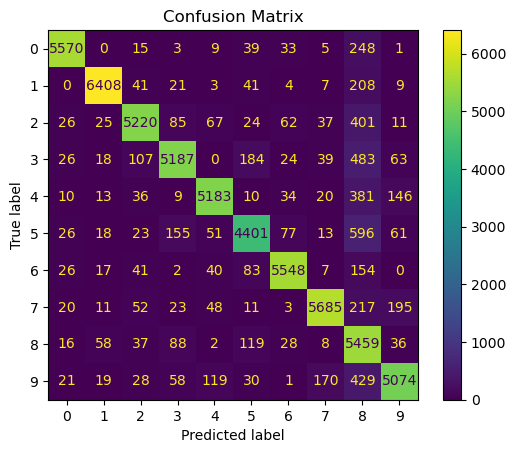

In [ ]:
# Plots the confusion matrix

ConfusionMatrixDisplay.from_predictions(y_train, cv_predictions)

plt.title("Confusion Matrix")
plt.show()

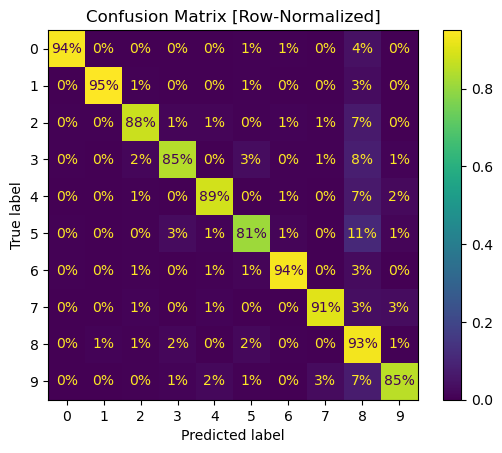

In [25]:
# Plots the normalized confusion matrix by dividing each value by the total number of images in the
# corresponding (true) class (i.e., divide by the row’s sum).
    
ConfusionMatrixDisplay.from_predictions(y_train, cv_predictions, normalize="true", values_format=".0%")

plt.title("Confusion Matrix [Row-Normalized]")
plt.show()

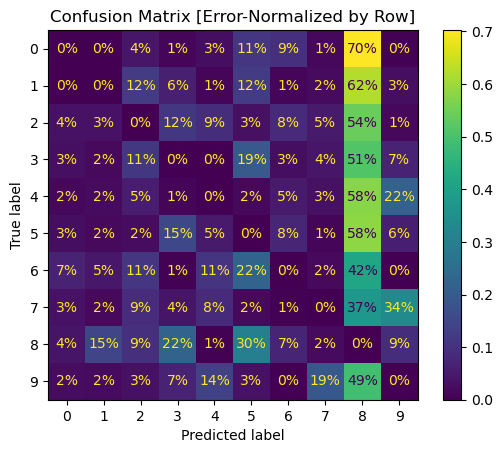

In [ ]:
# Renders the confusion matrix to emphasis more on incorrect predictions than the correct predictions

sample_weight = (cv_predictions != y_train) 

ConfusionMatrixDisplay.from_predictions(
    y_train, cv_predictions, sample_weight=sample_weight, normalize="true", values_format=".0%")
plt.title("Confusion Matrix [Error-Normalized by Row]")
plt.show()


The column for class 8 is now really bright, which confirms that many images got misclassified as 8s. In fact this is the most common misclassification for  almost all classes.

Possible solutions towards improving performance could be
- Gathering more training data for digits that look like 8s (but are not) so that the classifier can learn to distinguish them from real 8s
- Engineering new features that would help the classifier—for example, writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none)
- Augmenting the training set with slightly shifted and rotated variants of the training images.

## Multilabel Classification
Classifying multiple binary outputs for each instance with more than one binary class tagged.

In addition to predicting the class of an image in this experiment, let's also try to predict if the number is even or odd. Classifiers such as KNeighborsClassifier has built-in support multilabel classification.

In [13]:
# Creates an additional label indicating if the instance if even or odd.
y_train_odd = (y_train % 2 == 1)
y_test_odd = (y_test % 2 == 1)

# Combines both the labels - the original and the calculated one
y_train_multi = np.c_[y_train_5, y_train_odd]
y_test_multi = np.c_[y_test_5, y_test_odd]

In [14]:
# Initializes classifier
knn_clf = KNeighborsClassifier(n_jobs=-1)

# Fits the model
knn_clf.fit(X_train, y_train_multi)

KNeighborsClassifier(n_jobs=-1)

In [15]:
# Takes one sample from test set, performs prediction and then compares with the actual label
print("Prediction:", knn_clf.predict(X_test[:1]))
print("Actual Labels:", y_test_multi[:1])

Prediction: [[False  True]]
Actual Labels: [[False  True]]


Both the predicted labels were found to be correct as first instance in the test set is '7', which is non-5 and it is odd.

### Measuring Performance of Multilabel Classifiers

In [16]:
# Initializes classifier
knn_clf = KNeighborsClassifier(n_jobs=-1)

# For each fold, the model gets trained on the remaining folds and then 
# performs predictions on each sample on that fold
# NOTE: This step may take several tens of minutes to complete
cv_predictions_knn = cross_val_predict(
    knn_clf, X_train, y_train_multi, cv=5, verbose=3, method="predict")

In [18]:
# Measures the F1 score for each individual label, then computes the average score.
f1_score(y_train_multi, cv_predictions_knn, average="macro")

0.973175658353335

## Multioutput Classification
Classifying multiple multiclass outputs for each instances.

The following experiments removes noise from images. The model gets trained on noisy image with clear images as labels, and then produces a clear image from the noisy image during prediction. The model outputs 784 different values - each ranges from 0 to 255 (for grayscale images).

In [20]:
# Prepares data set

# Adds the noise to traning data
X_train_noise = X_train + np.random.randint(0, 100, (len(X_train), 784))

# Also adds noise for testing data
X_test_noise = X_test + np.random.randint(0, 100, (len(X_test), 784))

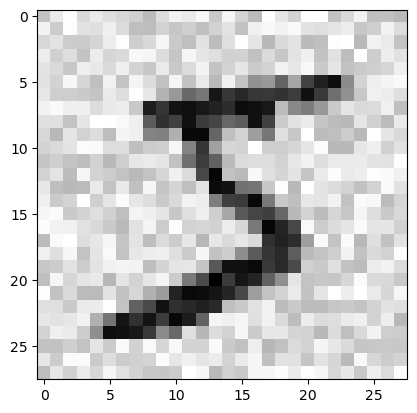

In [21]:
# Shows how a noisy image looks like

plt.imshow(X_train_noise[:1].reshape(28, 28), cmap="binary")
plt.show()

In [22]:
# Now, train a classifier to remove the noise from the images

# Initializes classifier
knn_clf = KNeighborsClassifier(n_jobs=-1)

# Fits the model
# NOTE: This step may take several seconds to complete
knn_clf.fit(X_train_noise, X_train)     # X_train as true label

KNeighborsClassifier(n_jobs=-1)

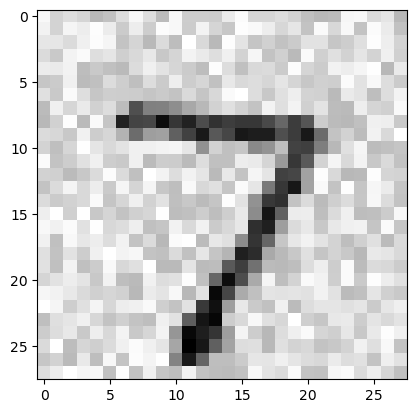

In [23]:
# Before performing prediction on the first instance on the test set, it
# first shows it looks after adding the noise

plt.imshow(X_test_noise[:1].reshape(28, 28), cmap="binary")
plt.show()

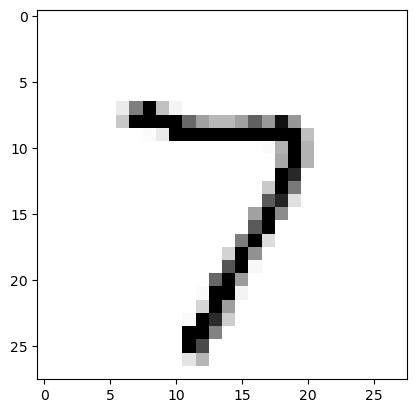

In [24]:
# Now, performs prediction to recieve a cleaned version of the above image 
clean_image = knn_clf.predict(X_test_noise[:1])

plt.imshow(clean_image.reshape(28, 28), cmap="binary")
plt.show()